In [3]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [4]:
# file paths (save data on your machine in the same format)
csv1_file_path = "~/Desktop/DataFiles/FRNSW_data_export_daily_20250513.csv"  
csv2_file_path = "~/Desktop/DataFiles/combined_attributes.csv" 

In [5]:
# expand the '~' to the full path
csv1_file_path = os.path.expanduser(csv1_file_path)
csv2_file_path = os.path.expanduser(csv2_file_path)

In [6]:
# reading in the files
csv1_data = pd.read_csv(csv1_file_path, encoding='latin1') 
csv2_data = pd.read_csv(csv2_file_path, encoding='latin1')
csv2_data = csv2_data.iloc[:, 1:]  # drops the first column

In [25]:
# convert REPORT_DATE to the appropriate datetime for consistent merging
csv1_data['REPORT_DATE'] = pd.to_datetime(csv1_data['REPORT_DATE'], format='%m/%d/%Y')
csv2_data['REPORT_DATE'] = pd.to_datetime(csv2_data['REPORT_DATE'], format='%m/%d/%Y')

In [31]:
# merging the dataframes on the REPORT_DATE column
merged_data = pd.merge(csv1_data, csv2_data, on="REPORT_DATE", how="inner")

In [33]:
# preview the merged data
print(merged_data.head())

  REPORT_DATE  FIRES_INCDS  WIRES_DOWN_INCDS  MEDICAL_INCDS  \
0  2024-11-26           87                 5             51   
1  2024-11-26           87                 5             51   
2  2024-11-25           91                 6             34   
3  2024-11-25           91                 6             34   
4  2024-11-24           87                 4             29   

   BUSH_AND_GRASS_FIRE_INCDS  HAZARDOUS_MATERIAL_INCDS  RESCUE_INCDS  \
0                         21                        34            39   
1                         21                        34            39   
2                         25                        34            26   
3                         25                        34            26   
4                         30                        21            37   

   STORM_RELATED_INCDS  AUTOMATIC_FIRE_ALARM_INCDS  OTHER_INCDS  ...  \
0                    5                         197           71  ...   
1                    5                      

In [10]:
# define constants for column names
FIRE_INCIDENTS_COLUMN = 'FIRES_INCDS'
WIND_SPEED_COLUMN = '9am wind speed (km/h)'
TEMPERATURE_COLUMN = '9am Temperature'
HUMIDITY_COLUMN = '9am relative humidity (%)'
CLOUD_AMOUNT_COLUMN = '9am cloud amount (oktas)'
PRESSURE_COLUMN = '9am MSL pressure (hPa)'

In [11]:
# SOME DATA CLEANING --> replace 'Calm' with 0 in wind speed columns
merged_data[WIND_SPEED_COLUMN] = pd.to_numeric(
    merged_data[WIND_SPEED_COLUMN].replace(r'(?i)^\s*calm\s*$', 0, regex=True),
    errors='coerce'
)

In [12]:
# DATA INTEGRITY --> ensure all required columns are numeric
columns_to_check = [
    FIRE_INCIDENTS_COLUMN,
    TEMPERATURE_COLUMN, 
    HUMIDITY_COLUMN, 
    CLOUD_AMOUNT_COLUMN, 
    WIND_SPEED_COLUMN, 
    PRESSURE_COLUMN
]
merged_data[columns_to_check] = merged_data[columns_to_check].apply(pd.to_numeric, errors='coerce')

In [13]:
# drop rows with missing values for these columns
cleaned_data = merged_data.dropna(subset=columns_to_check)

In [14]:
# calculate the correlation matrix
correlation_matrix = cleaned_data[columns_to_check].corr()

In [15]:
# displaying the correlation matrix
print(correlation_matrix)

                           FIRES_INCDS  9am Temperature  \
FIRES_INCDS                   1.000000         0.189995   
9am Temperature               0.189995         1.000000   
9am relative humidity (%)    -0.424009        -0.294080   
9am cloud amount (oktas)     -0.333604         0.010351   
9am wind speed (km/h)         0.126692        -0.247337   
9am MSL pressure (hPa)       -0.130876        -0.333062   

                           9am relative humidity (%)  \
FIRES_INCDS                                -0.424009   
9am Temperature                            -0.294080   
9am relative humidity (%)                   1.000000   
9am cloud amount (oktas)                    0.364859   
9am wind speed (km/h)                      -0.263188   
9am MSL pressure (hPa)                      0.401989   

                           9am cloud amount (oktas)  9am wind speed (km/h)  \
FIRES_INCDS                               -0.333604               0.126692   
9am Temperature                      

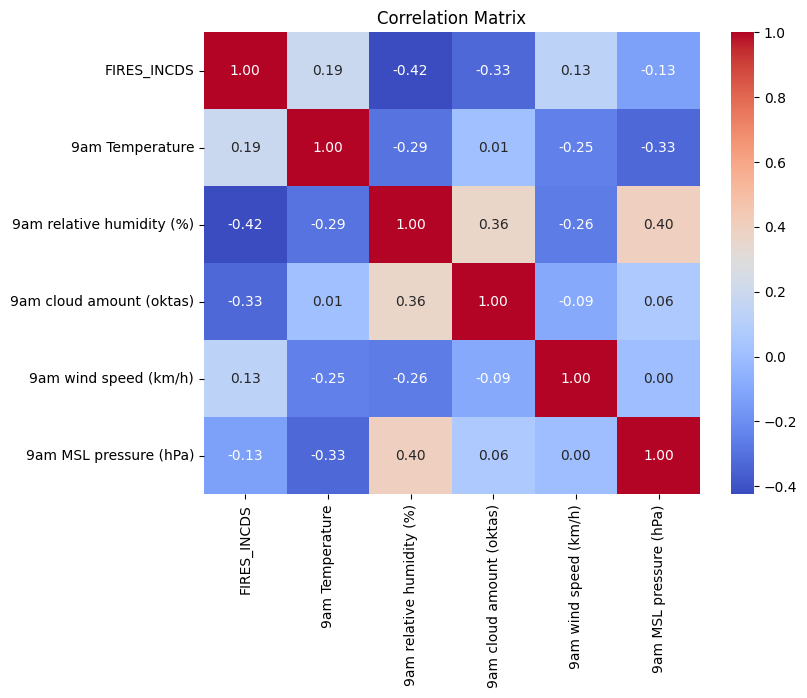

In [16]:
# heatmap for better visualisation
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [17]:
# summary statistics
print(merged_data.describe())

                         REPORT_DATE  FIRES_INCDS  WIRES_DOWN_INCDS  \
count                            478   478.000000        478.000000   
mean   2024-07-29 12:33:08.284518912    80.560669          6.447699   
min              2024-04-01 00:00:00    56.000000          0.000000   
25%              2024-05-30 06:00:00    71.000000          3.000000   
50%              2024-07-30 00:00:00    80.000000          4.000000   
75%              2024-09-27 18:00:00    88.000000          6.000000   
max              2024-11-26 00:00:00   124.000000        101.000000   
std                              NaN    12.761786         11.103307   

       MEDICAL_INCDS  BUSH_AND_GRASS_FIRE_INCDS  HAZARDOUS_MATERIAL_INCDS  \
count     478.000000                 478.000000                478.000000   
mean       34.635983                  10.702929                 26.707113   
min        15.000000                   0.000000                 11.000000   
25%        28.000000                   5.000000     

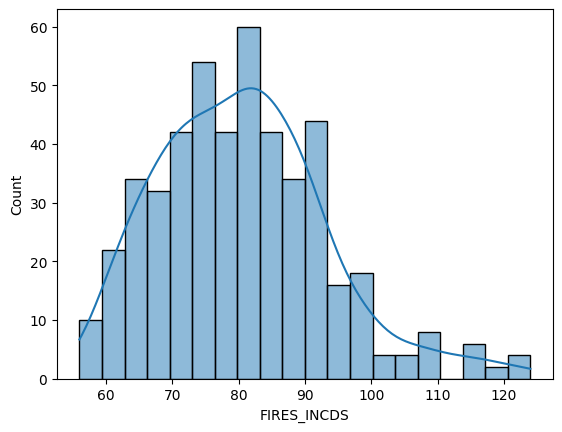

In [18]:
# distribution plot
sns.histplot(merged_data['FIRES_INCDS'], bins=20, kde=True)
plt.show()

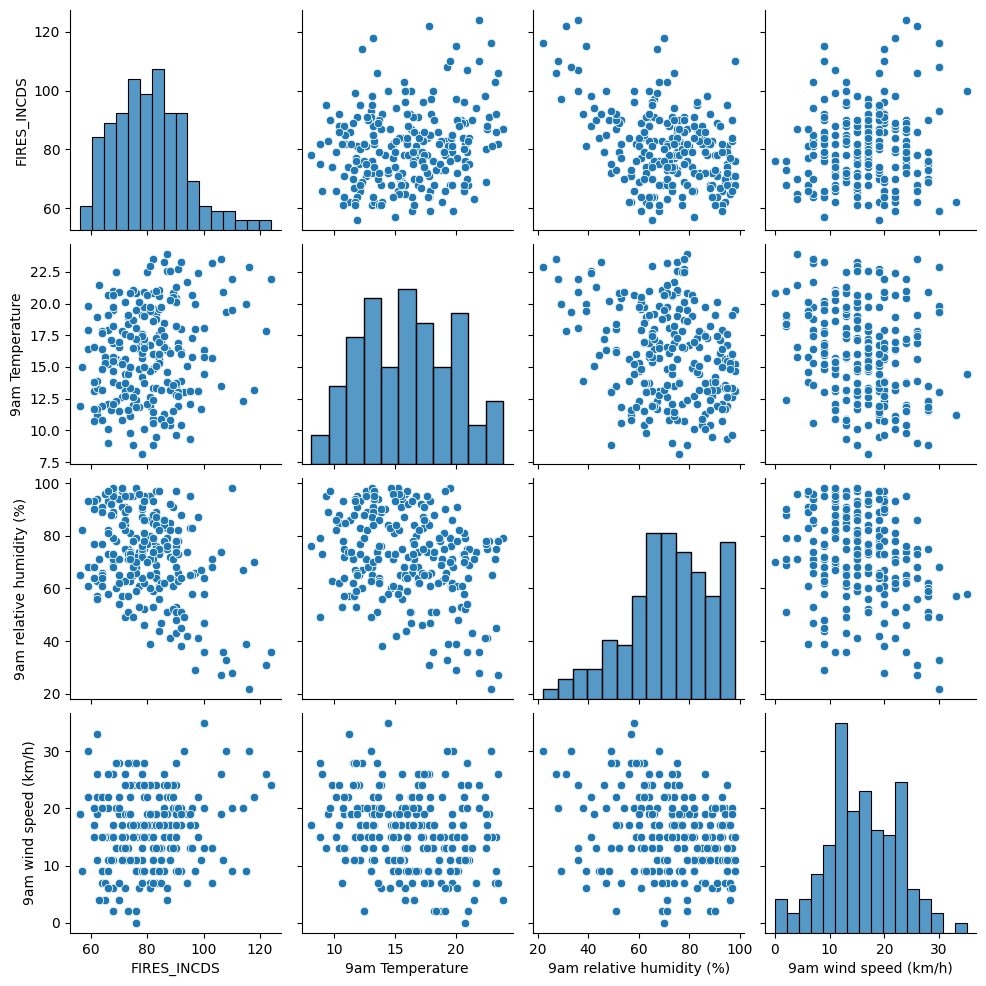

In [19]:
# pairplot to spot relationship
sns.pairplot(merged_data[['FIRES_INCDS', '9am Temperature', '9am relative humidity (%)', '9am wind speed (km/h)']])
plt.show()

In [20]:
# regression analysis
predictors = ["9am relative humidity (%)", "9am wind speed (km/h)", "9am Temperature"]  
target = "FIRES_INCDS"  

In [21]:
regression_data = merged_data.dropna(subset=predictors + [target])
X = regression_data[predictors]
y = regression_data[target]

In [22]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [23]:
# Print coefficients 
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("R^2 score:", model.score(X, y))

Coefficients: [-0.29499243  0.08960723  0.30316481]
Intercept: 95.47440015498167
R^2 score: 0.18625239531698023


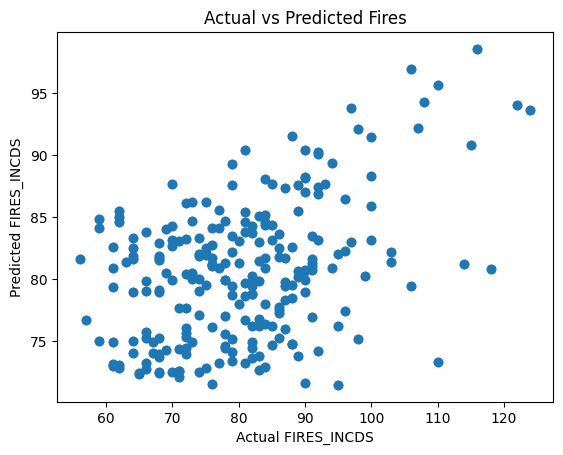

In [24]:
# plot actual vs predicted
y_pred = model.predict(X)
plt.scatter(y, y_pred)
plt.xlabel("Actual FIRES_INCDS")
plt.ylabel("Predicted FIRES_INCDS")
plt.title("Actual vs Predicted Fires")
plt.show()